In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('../banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:46, 1894.81it/s]


In [4]:
len(responses)

153499

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [5]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [6]:
data = pd.DataFrame(responses)
data.head()

author     bank_license        bank_name            city  \
0       uhnov1  лицензия № 2562          Бинбанк       г. Москва   
1       Foryou  лицензия № 1481  Сбербанк России  г. Новосибирск   
2   Vladimir84  лицензия № 2562          Бинбанк       г. Москва   
3       643609  лицензия № 1481  Сбербанк России   г. Ставрополь   
4  anfisa-2003  лицензия № 2766         ОТП Банк    г. Челябинск   

              datetime  num_comments  rating_grade  rating_not_checked  \
0  2015-06-08 12:50:54             0           NaN               False   
1  2015-06-08 11:09:57             0           NaN               False   
2  2015-06-05 20:14:28             1           NaN               False   
3  2015-06-05 13:51:01             2           NaN               False   
4  2015-06-05 10:58:12             1           NaN               False   

                                                text  \
0  Добрый день! Я не являюсь клиентом банка и пор...   
1  Доброго дня! Являюсь держателем зарплатной кар...   
2  Здравствуйте!  Дублирую свое заявление от 03.0...   
3  Добрый день!! Я открыл расчетный счет в СберБа...   
4  04.03.2015 г. взяла кредит в вашем банке, заяв...   

                                               title  
0                                             Жалоба  
1      Не могу пользоваться услугой Сбербанк он-лайн  
2                    Двойное списание за один товар.  
3  Меняют проценты комиссии  не предупредив и не ...  
4             Верните денежные средства за страховку

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки

In [7]:
res_city = {}

for i in responses:
    res_city[i['city']] = res_city[i['city']]+1 if i['city'] in res_city else 1
print(res_city)
    

{'г. Москва': 55354, 'г. Новосибирск': 2300, 'г. Ставрополь': 696, 'г. Челябинск': 1507, 'г. Волгоград': 1014, 'г. Пермь': 1163, 'г. Ростов-на-Дону': 1891, 'г. Воронеж': 1210, 'г. Таганрог (Ростовская обл.)': 8, 'г. Санкт-Петербург': 14342, 'г. Конаково': 9, 'г. Мурманск': 434, 'г. Волгодонск (Ростовская обл.)': 7, 'г. Большеречье': 2, 'г. Одинцово (Московская обл.)': 8, 'г. Салават (Республика Башкортостан)': 4, 'г. Краснодар': 1262, 'г. Кострома': 160, 'г. Нижний Новгород': 1976, 'г. Орел': 234, 'г. Саратов': 933, 'г. Казань': 1440, 'г. Реутов (Московская обл.)': 3, 'г. Ульяновск': 500, 'г. Красноярск': 1236, 'г. Хабаровск': 681, 'г. Магнитогорск (Челябинская обл.)': 16, 'г. Фролово (Волгоградская обл.)': 1, 'г. Новочеркасск': 67, 'г. Чита': 126, 'г. таганрог': 8, 'г. Йошкар-Ола': 190, 'г. Нижний Тагил': 189, 'г. Ханты-Мансийск': 48, 'г. Россия': 204, 'г. Липецк': 461, 'г. Нижнекамск (Республика Татарстан)': 5, 'г. Тюмень': 656, 'г. Москва, Санкт-Петербург': 3, 'г. Кизел': 2, 'г. Мон

In [8]:
print(len(res_city)) #всего уникальных названий городов

In [9]:
regex = r'г\. ([А-Яа-я- ]+)'
def get_city(text, regex=regex):
    try:
        values = re.findall(regex, text)
        return ' '.join(values).lower()
    except:
        return ""

### количество отзывов в разных городах

In [10]:
cities=data.groupby(['city']).count()['text'].sort_values( ascending=False).head(20)

5824


Text(0.5, 0, 'Количество отзывов')

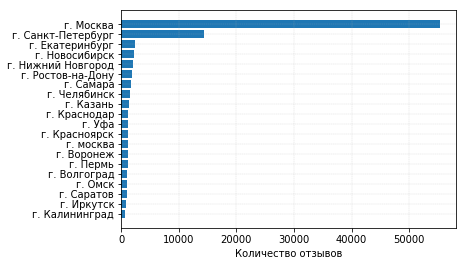

In [11]:
plt.barh(cities.index[::-1],cities.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('Количество отзывов')

### количество отзывов на разные банки

In [12]:
res_bank_name = {}

for i in responses:
    res_bank_name[i['bank_name']] = res_bank_name[i['bank_name']]+1 if i['bank_name'] in res_bank_name else 1
print(res_bank_name)

{'Бинбанк': 1646, 'Сбербанк России': 26327, 'ОТП Банк': 3237, 'Гагаринский': 19, 'Тинькофф Банк': 5387, 'Восточный Экспресс Банк': 3138, 'ВТБ 24': 8185, 'Альфа-Банк': 10224, 'БИНБАНК кредитные карты': 1464, 'МТС Банк': 1870, 'Совкомбанк': 919, 'Россельхозбанк': 532, 'Московский Кредитный Банк': 2944, 'МДМ Банк': 776, 'Хоум Кредит Банк': 7549, 'Бенифит-Банк': 115, 'Уральский Банк Реконструкции и Развития': 532, 'Русский Стандарт': 7943, 'Лето Банк': 501, 'Петрокоммерц': 339, 'Русфинанс Банк': 723, 'Киви Банк': 1741, 'Ханты-Мансийский банк Открытие': 2158, 'Русславбанк': 715, 'Татфондбанк': 159, 'МАСТ-Банк': 208, 'Национальный Банк «Траст»': 4607, 'Военно-Промышленный Банк': 149, 'АктивКапитал Банк': 75, 'Связной Банк': 3775, 'Платежный Центр': 13, 'Московский Индустриальный Банк': 271, 'Финансовый Стандарт': 125, 'Ренессанс Кредит': 3849, 'Югра': 451, 'ЮниКредит Банк': 2488, 'Банкирский Дом': 43, 'Кредит Европа Банк': 1683, 'Тройка-Д Банк': 13, 'ДельтаКредит': 501, 'Сетелем Банк': 1351,

In [13]:
print(len(res_bank_name)) #всего уникальных названий банков

670


In [14]:
banks=data.groupby(['bank_name']).count()['text'].sort_values( ascending=False).head(20)

Text(0.5, 0, 'Количество отзывов')

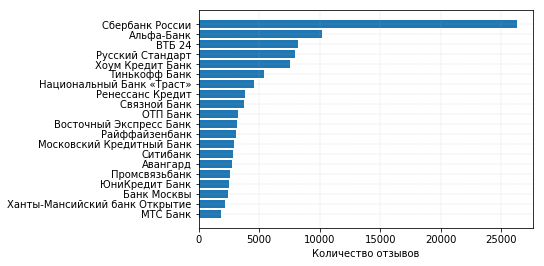

In [15]:
plt.barh(banks.index[::-1],banks.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('Количество отзывов')

In [16]:
df = pd.DataFrame(responses[:10000])
df.head()

author     bank_license        bank_name            city  \
0       uhnov1  лицензия № 2562          Бинбанк       г. Москва   
1       Foryou  лицензия № 1481  Сбербанк России  г. Новосибирск   
2   Vladimir84  лицензия № 2562          Бинбанк       г. Москва   
3       643609  лицензия № 1481  Сбербанк России   г. Ставрополь   
4  anfisa-2003  лицензия № 2766         ОТП Банк    г. Челябинск   

              datetime  num_comments  rating_grade  rating_not_checked  \
0  2015-06-08 12:50:54             0           NaN               False   
1  2015-06-08 11:09:57             0           NaN               False   
2  2015-06-05 20:14:28             1           NaN               False   
3  2015-06-05 13:51:01             2           NaN               False   
4  2015-06-05 10:58:12             1           NaN               False   

                                                text  \
0  Добрый день! Я не являюсь клиентом банка и пор...   
1  Доброго дня! Являюсь держателем зарплатной кар...   
2  Здравствуйте!  Дублирую свое заявление от 03.0...   
3  Добрый день!! Я открыл расчетный счет в СберБа...   
4  04.03.2015 г. взяла кредит в вашем банке, заяв...   

                                               title  
0                                             Жалоба  
1      Не могу пользоваться услугой Сбербанк он-лайн  
2                    Двойное списание за один товар.  
3  Меняют проценты комиссии  не предупредив и не ...  
4             Верните денежные средства за страховку

In [17]:
df.rating_not_checked.value_counts()

False    10000
Name: rating_not_checked, dtype: int64

In [18]:
del df['rating_not_checked']

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
author          10000 non-null object
bank_license    10000 non-null object
bank_name       10000 non-null object
city            10000 non-null object
datetime        10000 non-null object
num_comments    10000 non-null int64
rating_grade    4150 non-null float64
text            10000 non-null object
title           10000 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 703.2+ KB


In [20]:
df.describe()

num_comments  rating_grade
count  10000.000000   4150.000000
mean       2.277900      1.851807
std        3.928793      1.347705
min        0.000000      1.000000
25%        0.000000      1.000000
50%        1.000000      1.000000
75%        3.000000      2.000000
max       95.000000      5.000000

In [21]:
len_data = df.text.apply(len)
len_data.describe()

count    10000.000000
mean      1385.266100
std       1198.129411
min         41.000000
25%        638.000000
50%       1047.000000
75%       1711.000000
max      12837.000000
Name: text, dtype: float64

In [22]:
df.rating_grade.fillna(value=0, inplace=True) #заменить все NaN нулями
df.rating_grade.describe()

count    10000.000000
mean         0.768500
std          1.259471
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: rating_grade, dtype: float64

In [23]:
df.rating_grade.value_counts()

0.0    5850
1.0    2585
2.0     660
5.0     471
3.0     311
4.0     123
Name: rating_grade, dtype: int64

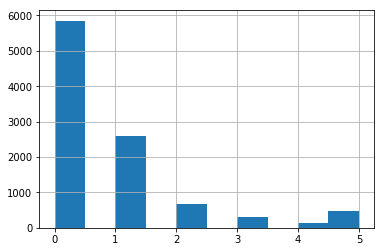

In [24]:
#гистограмма оценок
df.rating_grade.hist()

2. Постройте гистограмы длин слов в символах и в словах

In [25]:
import matplotlib.pyplot as plt
import numpy as np 
counts = df.title.value_counts()
counts = counts.head(100)
counts

Благодарность                                                32
Жалоба                                                       30
Реструктуризация                                             30
Звонки из банка                                              28
Претензия                                                    28
                                                             26
Телефонный терроризм                                         24
Некомпетентность сотрудников                                 17
Некомпетентные сотрудники                                    14
Кредитная карта                                              14
Перевыпуск карты                                             14
Звонки                                                       13
Звонки по чужому кредиту                                     13
Открытие вклада                                              13
Отвратительное обслуживание                                  12
Ужасное обслуживание                    

In [26]:
values = counts.tolist()
labels = counts.index.tolist()
y_pos = np.arange(len(labels))

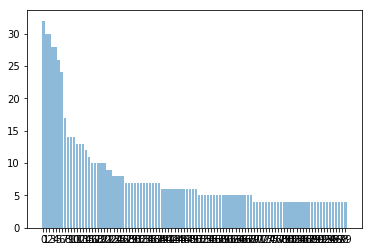

In [27]:
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, range(len(labels)))
plt.show()

In [28]:
counts1 = df.title.value_counts()

In [29]:
df_counts = pd.DataFrame(counts1)

In [30]:
df_counts.head(30).style.bar()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


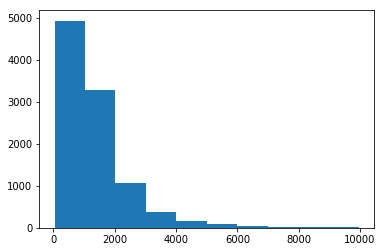

In [31]:
#Длины текстов (в символах)
fig, ax = plt.subplots()

length = len_data[len_data < 10000].tolist()

n, bins, patches = ax.hist(length)

fig.show()

3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных

In [32]:
#Используем регулярные выражения, чтобы разбить тексты на слова
import re
regex = re.compile("[А-Яа-яЁё]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

df.text.iloc[0]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каким либо другим лицом письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности начиная с марта года начали приходить бесконечные письма из ооо примо коллект на мой адрес город москва уваровский переулок дом квартира с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор от года и договор от года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают закон о защи

In [33]:
# Самые частые слова
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('в', 75560)
('и', 60839)
('не', 49717)
('на', 41269)
('что', 36343)
('я', 33614)
('с', 28473)
('по', 22747)
('мне', 19041)
('банка', 17330)


In [34]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [35]:
mystopwords = stopwords.words('russian') + ['г', 'Добрый день', 'Здравствуйте', 'доброго', 'дня', 'добрый', 'день', 'здравствуйте', 'В', 'тут-то', 'было', 'На', 'чуть-чуть', 'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-', 'Не', 'Как', 'без', 'рэ']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
 

In [36]:
df['text']= df.text.apply(remove_stopwords) 

In [37]:
# Самые частые слова без стоп-слов
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text'].split()
    tokens_all.append(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('банка', 17330)
('банк', 13989)
('деньги', 7068)
('карты', 6059)
('карту', 5677)
('кредит', 4663)
('банке', 4175)
('заявление', 3982)
('года', 3726)
('время', 3444)


In [38]:
tokens_all

[['являюсь',
  'клиентом',
  'банка',
  'поручителем',
  'кредитному',
  'договору',
  'являюсь',
  'каким',
  'либо',
  'другим',
  'лицом',
  'письменно',
  'оформившим',
  'отношения',
  'банком',
  'поводу',
  'урегулирования',
  'чьей',
  'либо',
  'задолженности',
  'начиная',
  'марта',
  'года',
  'начали',
  'приходить',
  'бесконечные',
  'письма',
  'ооо',
  'примо',
  'коллект',
  'адрес',
  'город',
  'москва',
  'уваровский',
  'переулок',
  'дом',
  'квартира',
  'угрозами',
  'возбуждении',
  'уголовного',
  'дела',
  'отношении',
  'гражданина',
  'филиппова',
  'эдуарда',
  'владимировича',
  'который',
  'уклоняется',
  'уплаты',
  'взятых',
  'кредитов',
  'договор',
  'года',
  'договор',
  'года',
  'всей',
  'ответственностью',
  'хочу',
  'заверить',
  'вышеуказанный',
  'гражданин',
  'которого',
  'разыскиваете',
  'знаком',
  'моем',
  'адресе',
  'зарегистрирован',
  'каким',
  'образом',
  'удостоверившись',
  'подлинности',
  'документов',
  'оформили',
  

In [39]:
df.head()

author     bank_license        bank_name            city  \
0       uhnov1  лицензия № 2562          Бинбанк       г. Москва   
1       Foryou  лицензия № 1481  Сбербанк России  г. Новосибирск   
2   Vladimir84  лицензия № 2562          Бинбанк       г. Москва   
3       643609  лицензия № 1481  Сбербанк России   г. Ставрополь   
4  anfisa-2003  лицензия № 2766         ОТП Банк    г. Челябинск   

              datetime  num_comments  rating_grade  \
0  2015-06-08 12:50:54             0           0.0   
1  2015-06-08 11:09:57             0           0.0   
2  2015-06-05 20:14:28             1           0.0   
3  2015-06-05 13:51:01             2           0.0   
4  2015-06-05 10:58:12             1           0.0   

                                                text  \
0  являюсь клиентом банка поручителем кредитному ...   
1  являюсь держателем зарплатной карты выданной с...   
2  дублирую свое заявление можайский мною моей де...   
3  открыл расчетный счет сбербанке юр лицо одно д...   
4  взяла кредит вашем банке заявленная мною сумма...   

                                               title  
0                                             Жалоба  
1      Не могу пользоваться услугой Сбербанк он-лайн  
2                    Двойное списание за один товар.  
3  Меняют проценты комиссии  не предупредив и не ...  
4             Верните денежные средства за страховку

In [40]:
# Лемматизация
from pymystem3 import Mystem

In [41]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip() 
    except:
        return " "

    
mystoplemmas = stopwords.words('russian') + ['который','прошлый','сей', 'свой', 'наш', 'мочь']
    
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""    
       
def preprocessing(text):
    lemmas = lemmatize(text)
    lemmas = remove_stoplemmas(lemmas)
    return(lemmas)

In [42]:
%time df['lemma'] = df.text.apply(lambda x: preprocessing(x))

CPU times: user 8.4 s, sys: 1.02 s, total: 9.42 s
Wall time: 1min 20s


In [43]:
df.head()

author     bank_license        bank_name            city  \
0       uhnov1  лицензия № 2562          Бинбанк       г. Москва   
1       Foryou  лицензия № 1481  Сбербанк России  г. Новосибирск   
2   Vladimir84  лицензия № 2562          Бинбанк       г. Москва   
3       643609  лицензия № 1481  Сбербанк России   г. Ставрополь   
4  anfisa-2003  лицензия № 2766         ОТП Банк    г. Челябинск   

              datetime  num_comments  rating_grade  \
0  2015-06-08 12:50:54             0           0.0   
1  2015-06-08 11:09:57             0           0.0   
2  2015-06-05 20:14:28             1           0.0   
3  2015-06-05 13:51:01             2           0.0   
4  2015-06-05 10:58:12             1           0.0   

                                                text  \
0  являюсь клиентом банка поручителем кредитному ...   
1  являюсь держателем зарплатной карты выданной с...   
2  дублирую свое заявление можайский мною моей де...   
3  открыл расчетный счет сбербанке юр лицо одно д...   
4  взяла кредит вашем банке заявленная мною сумма...   

                                               title  \
0                                             Жалоба   
1      Не могу пользоваться услугой Сбербанк он-лайн   
2                    Двойное списание за один товар.   
3  Меняют проценты комиссии  не предупредив и не ...   
4             Верните денежные средства за страховку   

                                               lemma  
0  являться клиент банк поручитель кредитный дого...  
1  являться держатель зарплатной карта выдавать с...  
2  дублировать заявление можайский дебетовый карт...  
3  открывать расчетный счет сбербанк юр лицо дого...  
4  взять кредит ваш банк заявлять сумма рубль год...

In [44]:
#tokens_all = ','.join(tokens_all[1])
#tokens_all

In [45]:
# Самые частые леммы

In [46]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)



#all_lemmas = []
#for i in tqdm(range(len(tokens_all))):
   # tokens = tokens_all.split()
    
   # lemma.append(m.lemmatize(index))
    
   # all_lemmas.append(''.join(lemmas))
   # cnt.update(lemmas)
   # n_types.append(len(cnt))
   # n_tokens.append(sum(cnt.values()))
#for i in cnt.most_common(10):
   # print(i)


('банк', 39030)
('карта', 18950)
('кредит', 9776)
('деньги', 9575)
('сотрудник', 9373)
('клиент', 7981)
('счет', 7892)
('сумма', 6997)
('отделение', 6909)
('год', 6642)


In [47]:
#существительные

In [48]:
from pymorphy2 import MorphAnalyzer

In [49]:
def to_nouns(text, mystem=m):
    
    m=MorphAnalyzer()
    try:
        
        return  " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return []
to_nouns(df.lemma.iloc[1])

'держатель карта сбербанк россия год фамилия банк документ копия паспорт свидетельство брак карта фамилия муж токарева мария александровна секлетина необходимость услуга сбербанк страница карта специалист отделение сбербанк база банк фамилия секлетина скан документ контакт звонок ч время ситуация база секлетина карта фамилия токарева связь истечение срок обслуживание документ копия паспорт свидетельство брак результат ноль ситуация уважение токарев мария александровна'

In [50]:
%%time
from multiprocessing import Pool
with Pool() as p:
    df['nouns']=p.map(to_nouns,df.lemma)

CPU times: user 433 ms, sys: 381 ms, total: 813 ms
Wall time: 7min 59s


In [51]:
df.head()

author     bank_license        bank_name            city  \
0       uhnov1  лицензия № 2562          Бинбанк       г. Москва   
1       Foryou  лицензия № 1481  Сбербанк России  г. Новосибирск   
2   Vladimir84  лицензия № 2562          Бинбанк       г. Москва   
3       643609  лицензия № 1481  Сбербанк России   г. Ставрополь   
4  anfisa-2003  лицензия № 2766         ОТП Банк    г. Челябинск   

              datetime  num_comments  rating_grade  \
0  2015-06-08 12:50:54             0           0.0   
1  2015-06-08 11:09:57             0           0.0   
2  2015-06-05 20:14:28             1           0.0   
3  2015-06-05 13:51:01             2           0.0   
4  2015-06-05 10:58:12             1           0.0   

                                                text  \
0  являюсь клиентом банка поручителем кредитному ...   
1  являюсь держателем зарплатной карты выданной с...   
2  дублирую свое заявление можайский мною моей де...   
3  открыл расчетный счет сбербанке юр лицо одно д...   
4  взяла кредит вашем банке заявленная мною сумма...   

                                               title  \
0                                             Жалоба   
1      Не могу пользоваться услугой Сбербанк он-лайн   
2                    Двойное списание за один товар.   
3  Меняют проценты комиссии  не предупредив и не ...   
4             Верните денежные средства за страховку   

                                               lemma  \
0  являться клиент банк поручитель кредитный дого...   
1  являться держатель зарплатной карта выдавать с...   
2  дублировать заявление можайский дебетовый карт...   
3  открывать расчетный счет сбербанк юр лицо дого...   
4  взять кредит ваш банк заявлять сумма рубль год...   

                                               nouns  
0  клиент банк поручитель договор лицо отношение ...  
1  держатель карта сбербанк россия год фамилия ба...  
2  заявление карта покупка интернет магазин сумма...  
3  счет сбербанк юр лицо договор комиссия перевод...  
4  кредит банк сумма рубль год менеджер срок кред...

In [52]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun= []
tokens_noun = []
tokens_all_noun=[]
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['nouns'].split()
    cnt_noun.update(tokens)
    n_types_noun.append(len(cnt))
    tokens_all_noun+=tokens
    n_tokens_noun.append(sum(cnt.values()))
for i in cnt_noun.most_common(10):
    print(i)       


('банк', 39030)
('карта', 18950)
('кредит', 9776)
('деньги', 9575)
('сотрудник', 9373)
('клиент', 7981)
('счет', 7892)
('сумма', 6997)
('отделение', 6909)
('год', 6642)


4. Постройте кривые Ципфа и Хипса

### Закон Ципфа


В любом достаточно большом тексте ранг типа обратно пропорционален его частоте: $f = \frac{a}{r}$

$f$ – частота типа, $r$  – ранг типа, $a$  – параметр, для славянских языков – около 0.07

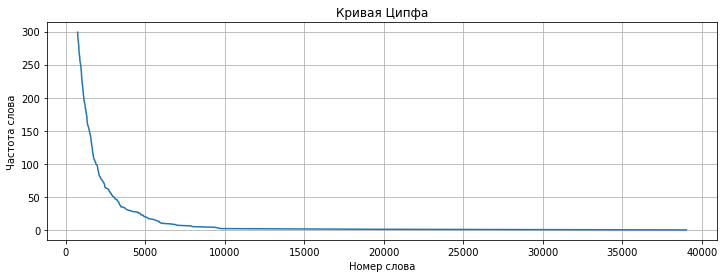

In [53]:
#кривая Ципфа

freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.grid()

plt.show()

### Закон Хипса

С увеличением длины текста (количества токенов), количество типов увеличивается в соответствии с законом: $|V| = K*N^b$


$N$  –  число токенов, $|V|$  – количество типов в словаре, $K, b$  –  параметры, обычно $K \in [10,100], b \in [0.4, 0.6]$

In [ ]:
#кривая Хипса
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(n_tokens,n_types)
plt.xlabel('Количество  токенов')
plt.ylabel('Число слов')
plt.title('Кривая Хипса')
plt.grid()

plt.show()

5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [55]:
from nltk import FreqDist
Freq_Dist = FreqDist(tokens_all)

In [56]:
#re.findall(pattern, string) - возвращает все вхождения pattern в string в виде списка
print(Freq_Dist['сотрудник'])

9373


In [57]:
print('Слово "сотрудник" встрчается -"',Freq_Dist['сотрудник'],'раз')
print('Слово "клиент" встрчается -"',Freq_Dist['клиент'],'раз')
print(Freq_Dist['сотрудник'] >Freq_Dist['клиент'])

Слово "сотрудник" встрчается -" 9373 раз
Слово "клиент" встрчается -" 7981 раз
True


In [58]:
print('Слово "мошенничество" встрчается -"',Freq_Dist['мошенничество'],'раз')
print('Слово "доверие" встрчается -"',Freq_Dist['доверие'],'раз')

Слово "мошенничество" встрчается -" 221 раз
Слово "доверие" встрчается -" 152 раз


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [59]:
df['rating_grade'].value_counts()

0.0    5850
1.0    2585
2.0     660
5.0     471
3.0     311
4.0     123
Name: rating_grade, dtype: int64

In [60]:
#т.к. выборка не сбалансированная, выберем по 5 тысяч семплов с положительной и негативной оценками
num=5000
df_for_tf_idf = data[(data.rating_grade==1)].sample(n=num).copy()
df_for_tf_idf=df_for_tf_idf.append(data[(data.rating_grade==5)].sample(n=num))
df_for_tf_idf.rating_grade.value_counts()

5.0    5000
1.0    5000
Name: rating_grade, dtype: int64

In [61]:
df_for_tf_idf['text'] = df_for_tf_idf.apply(lambda row: words_only(row['text']), axis=1)
df_for_tf_idf['text'] = df_for_tf_idf.apply(lambda row: remove_stopwords(row['text']), axis=1)
df_for_tf_idf['lemmas'] = df_for_tf_idf.apply(lambda row: lemmatize(row['text']), axis=1)
df_for_tf_idf['nouns'] = df_for_tf_idf.apply(lambda row: to_nouns(row['lemmas']), axis=1)

In [62]:
df_for_tf_idf

author                          bank_license  \
29657        oksana3103                       лицензия № 2827   
78009         gtgcbrjkf                       лицензия № 2827   
46771          FoxSorry                       лицензия № 3052   
146256             Спам        лицензия № 2295 (аннулирована)   
152553           Andrey                       лицензия № 2557   
77802       lesya-vinni                       лицензия № 1623   
52751              kvel                          лицензия № 1   
149848           thazul                       лицензия № 2306   
145253           AALLFF                       лицензия № 3279   
49931          Genn.123                       лицензия № 1481   
106237      Gulnaz26984                       лицензия № 1460   
104898     Fallen_Angel                       лицензия № 2879   
26081           bearing  лицензия № 625 (отозвана 26.11.2014)   
145849         Angel007                       лицензия № 1978   
22851          slturist                       лицензия № 1481   
147837       Андрианова                       лицензия № 1326   
146401         Юлия1981                       лицензия № 2289   
123496      vartbaronov                       лицензия № 1326   
81538   Tatyana Vredina                       лицензия № 1481   
34720        vkurilikin                       лицензия № 2763   
68894     katerinka1981                       лицензия № 1481   
15406         dalex2007                       лицензия № 1810   
21048              wakh                       лицензия № 1868   
95139           nathing                       лицензия № 1481   
5946          surgut_as                       лицензия № 3311   
40609         sseryogin                       лицензия № 3354   
116358         1laforce                       лицензия № 1481   
132763             Evgi                       лицензия № 3292   
131294       andrej2010                          лицензия № 1   
149046           kavlis                       лицензия № 2289   
...                 ...                                   ...   
151025         Manager1                       лицензия № 2771   
67151          ozzyback                       лицензия № 3279   
111967         $omebody                       лицензия № 3292   
112539           maltar                          лицензия № 1   
81983       Rorshah Nsk                       лицензия № 2209   
132202         Oldboy83                       лицензия № 3354   
151258            Ольга                          лицензия № 1   
44715           Pavelkk                       лицензия № 3368   
147258          Eugenix                       лицензия № 2557   
54758            1979NT                        лицензия № 826   
127220        w7701n618                        лицензия № 316   
122820           genato                       лицензия № 3267   
102770            Uraaa                          лицензия № 1   
122886         @G024680                       лицензия № 1326   
142730           UserXP                        лицензия № 128   
139202      swetik-1962                       лицензия № 1481   
92827             ged84                       лицензия № 2879   
137210        qwer_1234                       лицензия № 2879   
108938         W.A.S.P.                       лицензия № 2748   
129559          ulyasha                       лицензия № 2766   
41711          42goscha                       лицензия № 2227   
131896       Наташа1234                       лицензия № 3338   
139466          echinos                       лицензия № 2771   
144535         moneyman                       лицензия № 2412   
137757              idr                       лицензия № 2227   
147322         zyuzyuka                       лицензия № 2289   
24696           yaTaran                       лицензия № 1961   
139294            B-Rom                       лицензия № 2766   
153080            алекс                       лицензия № 2562   
96869         золот ник                       лиценз

In [63]:
tokens_by_rating = []

In [64]:
for rating_grade in df_for_tf_idf.rating_grade.unique():
    if df_for_tf_idf['rating_grade'].value_counts()[rating_grade] > 100: 
        print(rating_grade)
        tokens = []
        sample = df_for_tf_idf[df_for_tf_idf['rating_grade']==rating_grade]
        
        for i in range(len(sample)):
            tokens += sample.text.iloc[i].split()
        tokens_by_rating.append(tokens)

1.0
5.0


### Униграммы

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_5 = []
tfidf_ranking_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_1.append(phrase)

In [66]:
rankings = pd.DataFrame({'tfidf_ranking_5': tfidf_ranking_5,'tfidf_ranking_1': tfidf_ranking_1})
rankings.head(11)

tfidf_ranking_5 tfidf_ranking_1
0            банка           банка
1             банк            банк
2            очень          деньги
3           деньги           карту
4            карту           карты
5            банке       заявление
6           кредит       отделение
7          спасибо          кредит
8            время            счет
9            карты           банке
10          быстро           время

In [67]:
#видим большое количество пересечений слов в отзывах на уровне униграм
#необходимо удалить пресекающщиейся леммы

In [68]:
rankings['tfidf_ranking_5_without_1']=rankings.tfidf_ranking_5[~rankings.tfidf_ranking_5.isin(rankings.tfidf_ranking_1)]

In [69]:
rankings['tfidf_ranking_1_without_5']=rankings.tfidf_ranking_1[~rankings.tfidf_ranking_1.isin(rankings.tfidf_ranking_5)]

In [70]:
rankings.iloc[:,-2:].dropna()

tfidf_ranking_5_without_1 tfidf_ranking_1_without_5
12                  интернет                    почему
14                     вклад                     ответ
19                      хочу                   сказали
24                   вопросы                     номер
40                      пока                 сбербанка
42                        от                       мои
43                    работы                    вообще
45                  клиентом                     карте
52                       все                        вы
57                     общем                  получить
58                   очереди                     никто
59                     офисе                      мной
60                   сказать                       мне
66                    удобно                        по
68                   получил                       при
69                       лет                     сайте

### Биграммы

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase)

In [73]:
rankings = pd.DataFrame({'tfidf_ranking_5': tfidf_ranking_5,'tfidf_ranking_1': tfidf_ranking_1})
rankings.head(11)

tfidf_ranking_5 tfidf_ranking_1
0            банка           банка
1             банк            банк
2            очень          деньги
3           деньги           карту
4            карту           карты
5            банке       заявление
6           кредит       отделение
7          спасибо          кредит
8            время            счет
9            карты           банке
10          быстро           время

In [74]:
#удалим пересечения

In [75]:
rankings['tfidf_ranking_5_without_1']=rankings.tfidf_ranking_5[~rankings.tfidf_ranking_5.isin(rankings.tfidf_ranking_1)]

In [76]:
rankings['tfidf_ranking_1_without_5']=rankings.tfidf_ranking_1[~rankings.tfidf_ranking_1.isin(rankings.tfidf_ranking_5)]

In [77]:
#выведем результат
rankings.iloc[:,-2:].dropna()

tfidf_ranking_5_without_1 tfidf_ranking_1_without_5
12                  интернет                    почему
14                     вклад                     ответ
19                      хочу                   сказали
24                   вопросы                     номер
40                      пока                 сбербанка
42                        от                       мои
43                    работы                    вообще
45                  клиентом                     карте
52                       все                        вы
57                     общем                  получить
58                   очереди                     никто
59                     офисе                      мной
60                   сказать                       мне
66                    удобно                        по
68                   получил                       при
69                       лет                     сайте

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

Эта часть задания может быть сделана с использованием gensim. 

In [87]:
import gensim
from gensim.corpora import Dictionary
from gensim import corpora, models
from gensim.models import  LsiModel, LdaModel, TfidfModel

In [88]:
texts = [df.lemma.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [89]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [90]:
lsi_5 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

In [91]:
lsi_5.show_topics(5)

[(0,
  '0.195*"карта" + 0.138*"кредит" + 0.120*"деньги" + 0.117*"вклад" + 0.111*"счет" + 0.105*"заявление" + 0.102*"сумма" + 0.099*"сотрудник" + 0.099*"отделение" + 0.097*"номер"'),
 (1,
  '0.256*"вклад" + -0.248*"звонок" + -0.227*"номер" + 0.219*"карта" + -0.217*"кредит" + -0.175*"ваш" + -0.139*"телефон" + 0.134*"деньги" + 0.133*"банкомат" + -0.128*"персональный"'),
 (2,
  '0.619*"вклад" + -0.220*"карта" + 0.164*"договор" + -0.160*"банкомат" + 0.157*"ставка" + -0.157*"сбербанк" + 0.131*"открывать" + 0.130*"условие" + 0.124*"процент" + 0.110*"страховка"'),
 (3,
  '0.337*"страховка" + 0.297*"кредит" + -0.270*"вклад" + 0.243*"страхование" + -0.218*"номер" + -0.156*"звонок" + 0.139*"погашение" + 0.139*"платеж" + 0.134*"сумма" + 0.133*"договор"'),
 (4,
  '-0.210*"средство" + 0.196*"заявка" + -0.184*"денежный" + -0.172*"договор" + -0.172*"вклад" + -0.144*"сумма" + -0.138*"счет" + -0.136*"платеж" + -0.130*"руб" + 0.127*"отделение"')]

In [92]:
lsi_10 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

In [93]:
lsi_10.show_topics(10)

[(0,
  '0.195*"карта" + 0.138*"кредит" + 0.120*"деньги" + 0.117*"вклад" + 0.111*"счет" + 0.105*"заявление" + 0.102*"сумма" + 0.099*"сотрудник" + 0.099*"отделение" + 0.097*"номер"'),
 (1,
  '-0.255*"вклад" + 0.248*"звонок" + 0.227*"номер" + -0.219*"карта" + 0.217*"кредит" + 0.175*"ваш" + 0.139*"телефон" + -0.135*"деньги" + -0.133*"банкомат" + 0.128*"персональный"'),
 (2,
  '0.619*"вклад" + -0.220*"карта" + 0.164*"договор" + -0.161*"банкомат" + -0.158*"сбербанк" + 0.157*"ставка" + 0.132*"открывать" + 0.131*"условие" + 0.125*"процент" + 0.110*"страховка"'),
 (3,
  '-0.336*"страховка" + -0.297*"кредит" + 0.271*"вклад" + -0.244*"страхование" + 0.219*"номер" + 0.156*"звонок" + -0.139*"погашение" + -0.139*"платеж" + -0.135*"сумма" + -0.133*"договор"'),
 (4,
  '-0.210*"средство" + 0.197*"заявка" + -0.184*"денежный" + -0.173*"вклад" + -0.172*"договор" + -0.147*"сумма" + -0.139*"счет" + -0.136*"платеж" + -0.130*"руб" + 0.124*"отделение"'),
 (5,
  '0.263*"страхование" + 0.240*"страховка" + -0.230

In [94]:
lsi_20 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=20)

In [95]:
lsi_20.show_topics()

[(0,
  '0.195*"карта" + 0.138*"кредит" + 0.120*"деньги" + 0.117*"вклад" + 0.111*"счет" + 0.105*"заявление" + 0.102*"сумма" + 0.099*"сотрудник" + 0.099*"отделение" + 0.097*"номер"'),
 (1,
  '-0.255*"вклад" + 0.248*"звонок" + 0.227*"номер" + -0.219*"карта" + 0.217*"кредит" + 0.175*"ваш" + 0.139*"телефон" + -0.135*"деньги" + -0.134*"банкомат" + 0.128*"персональный"'),
 (2,
  '-0.620*"вклад" + 0.219*"карта" + -0.165*"договор" + 0.160*"банкомат" + 0.158*"сбербанк" + -0.157*"ставка" + -0.132*"открывать" + -0.131*"условие" + -0.124*"процент" + -0.110*"страховка"'),
 (3,
  '0.336*"страховка" + 0.298*"кредит" + -0.270*"вклад" + 0.243*"страхование" + -0.219*"номер" + -0.156*"звонок" + 0.140*"платеж" + 0.138*"погашение" + 0.135*"сумма" + 0.134*"договор"'),
 (4,
  '-0.212*"средство" + 0.198*"заявка" + -0.186*"денежный" + -0.175*"договор" + -0.172*"вклад" + -0.142*"сумма" + -0.139*"счет" + -0.137*"платеж" + -0.130*"руб" + 0.126*"отделение"'),
 (5,
  '0.262*"страхование" + 0.239*"страховка" + -0.227

In [96]:
from gensim.models.ldamulticore import LdaMulticore

In [ ]:
ldamodel_5 = LdaMulticore(corpus, num_topics=5, id2word = dictionary, passes=20, workers=5)

In [ ]:
ldamodel_5.show_topics()

In [99]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(ldamodel_5, corpus, dictionary)
pyLDAvis.display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [100]:
ldamodel_10 = LdaMulticore(corpus, num_topics=10, id2word = dictionary, passes=20, workers =5)
ldamodel_10.show_topics(10)

[(0,
  '0.031*"банк" + 0.030*"карта" + 0.017*"услуга" + 0.012*"кредитный" + 0.011*"смс" + 0.010*"год" + 0.009*"подключать" + 0.009*"лимит" + 0.008*"клиент" + 0.007*"рубль"'),
 (1,
  '0.016*"банк" + 0.013*"офис" + 0.012*"отделение" + 0.011*"деньги" + 0.010*"очередь" + 0.009*"клиент" + 0.009*"сказать" + 0.008*"минута" + 0.008*"приходить" + 0.007*"документ"'),
 (2,
  '0.040*"банк" + 0.026*"кредит" + 0.021*"сумма" + 0.015*"договор" + 0.011*"кредитный" + 0.011*"заявление" + 0.010*"страховка" + 0.009*"сотрудник" + 0.009*"рубль" + 0.009*"руб"'),
 (3,
  '0.026*"банк" + 0.016*"кредит" + 0.015*"платеж" + 0.013*"карта" + 0.012*"сказать" + 0.011*"деньги" + 0.010*"сумма" + 0.009*"месяц" + 0.009*"год" + 0.008*"счет"'),
 (4,
  '0.025*"банк" + 0.017*"счет" + 0.013*"карта" + 0.013*"средство" + 0.013*"деньги" + 0.011*"перевод" + 0.010*"ответ" + 0.009*"платеж" + 0.008*"клиент" + 0.007*"денежный"'),
 (5,
  '0.038*"банк" + 0.019*"звонок" + 0.018*"кредит" + 0.017*"номер" + 0.015*"сотрудник" + 0.014*"ваш" + 

In [101]:
from gensim.models.ldamulticore import LdaMulticore
ldamodel_20 = LdaMulticore(corpus, num_topics=20, id2word = dictionary, passes=20, workers =5)
ldamodel_20.show_topics(20)

[(0,
  '0.033*"договор" + 0.023*"документ" + 0.021*"банк" + 0.019*"кредит" + 0.014*"ооо" + 0.011*"кредитный" + 0.010*"предоставлять" + 0.009*"заявление" + 0.008*"сотрудник" + 0.008*"салон"'),
 (1,
  '0.044*"банк" + 0.027*"платеж" + 0.021*"кредит" + 0.020*"сумма" + 0.014*"кредитный" + 0.012*"задолженность" + 0.010*"счет" + 0.010*"погашение" + 0.009*"оплачивать" + 0.009*"рубль"'),
 (2,
  '0.014*"банк" + 0.014*"документ" + 0.011*"сотрудник" + 0.009*"вопрос" + 0.007*"ипотека" + 0.006*"отвечать" + 0.006*"сказать" + 0.005*"год" + 0.005*"муж" + 0.005*"закладная"'),
 (3,
  '0.033*"офис" + 0.019*"банк" + 0.013*"работать" + 0.011*"сотрудник" + 0.011*"банкомат" + 0.009*"клиент" + 0.008*"дверь" + 0.008*"город" + 0.007*"ваш" + 0.006*"очень"'),
 (4,
  '0.088*"доверенность" + 0.021*"александр" + 0.008*"нотариальный" + 0.007*"нотариус" + 0.005*"вопрос" + 0.005*"чук" + 0.005*"вклад" + 0.005*"доверенный" + 0.004*"ва" + 0.004*"генеральный"'),
 (5,
  '0.042*"банк" + 0.019*"договор" + 0.014*"рф" + 0.013*"з

In [102]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(ldamodel_10, corpus, dictionary)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [103]:
In [75]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(ldamodel_20, corpus, dictionary)
pyLDAvis.display(vis_data)

SyntaxError: invalid syntax (<ipython-input-103-85b90966fc03>, line 1)

2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [104]:
df.bank_name.value_counts(normalize=1).head()

Сбербанк России     0.1696
Альфа-Банк          0.0709
ВТБ 24              0.0616
Русский Стандарт    0.0560
Хоум Кредит Банк    0.0538
Name: bank_name, dtype: float64

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


NameError: name 'CountVectorizer' is not defined